# Linear image classification

We'll start with a simple model linear classifier. As we saw before, this kind of classifier will do poorly in cases in which the data cannot be separated with a hyper-plane. Still, it will be a good first stab at this, because some of the patterns of using TF will be easier to explain

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf

First, we need a function that will read the `tfrecords` file that we created in [`002-create-tfrecords`](002-create-tfrecords.ipynb). This function will do some rather elaborate magic under the hood to keep the data streaming through the computation graph. Importantly, it returns only a notional answer -- the `label` and `image` created here need to be computed as part of a TF session, so everything gets populated within the graph at run time.

In [3]:
def read_and_decode(filename):
    filename_queue = tf.train.string_input_producer([filename],
                                                    num_epochs=None)

    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    features = tf.parse_single_example(
        serialized_example,
        features={
                'image/height': tf.FixedLenFeature([], tf.int64),
                'image/width': tf.FixedLenFeature([], tf.int64),
                'image/depth': tf.FixedLenFeature([], tf.int64),
                'label': tf.FixedLenFeature([], tf.int64),
                'image/raw': tf.VarLenFeature(tf.string)})

    # Shape elements must be int32 tensors!
    height = tf.cast(features['image/height'], tf.int32)
    width = tf.cast(features['image/width'], tf.int32)
    depth = tf.cast(features['image/depth'], tf.int32)
    
    # Decode the image from its raw representation:
    image = tf.decode_raw(features['image/raw'].values, tf.uint8)

    # Reshape it back to its original shape:
    im_shape = tf.pack([height, width, depth])
    image = tf.reshape(image, im_shape)
    #tf.random_crop(image, [height, width, depth])
    # Convert from [0, 255] -> [0, 1] floats.
    image = tf.cast(image, tf.float32) * (1. / 255)

    # Convert label from a scalar uint8 tensor to an int32 scalar.
    label = tf.cast(features['label'], tf.int32)
    return image, label

For example 

In [4]:
image, label = read_and_decode('../data/cells_train.tfrecords')

In [5]:
image.get_shape()

TensorShape([Dimension(None), Dimension(None), Dimension(None)])

For example, here we start a session, initialize all the variables, start queues and run image and label once. This is tantamount to pulling out the first value from the tfrecords file:

In [6]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
tf.train.start_queue_runners(sess=sess)
im_1, lab_1 = sess.run([image, label])

In [7]:
im_1.shape

(256, 256, 3)

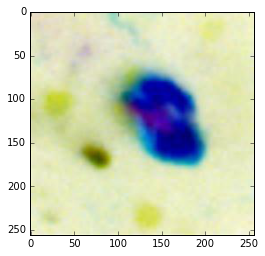

In [8]:
plt.imshow((im_1 * 255).astype(int), vmin=0, vmax=255)

In [9]:
lab_1

2

Below, we set up training. `train.shuffle_batch` is going to do the magic of pulling out examples from the training data. Each batch will have 40 examples. 

W and b are the model parameters (weights and bias). We define the loss function to be a cross-entropy 

Note that we *do not* pass the maximized `y_pred` into the `sparse_softmax_cross_entropy_with_logits`, because it does a softmax operation internally to derive the predicted class.

We calculate a mean loss, that we will use to keep track of what happened during training. Finally, we define an optimizer that will operate on these variables.

In [10]:
# get single examples
image, label = read_and_decode("../data/cells_train.tfrecords")

# The following groups the examples into batches randomly. This function requires explicitely setting the
# Shapes of the inputs, so we take advantage of the fact that we already pulled out one example above
images_batch, labels_batch = tf.train.shuffle_batch(
    [image, label], batch_size=40,
    capacity=400,
    shapes=(im_1.shape, lab_1.shape),
    min_after_dequeue=200)

# The model: y_pred = Wx + b
W = tf.Variable(tf.zeros([np.prod(im_1.shape), 3]))
b = tf.Variable(tf.zeros([3]))

y_pred = tf.matmul(tf.reshape(images_batch, [-1, np.prod(im_1.shape)]), W) + b
loss = tf.nn.sparse_softmax_cross_entropy_with_logits(y_pred, labels_batch)

# We can use this for monitoring:
loss_mean = tf.reduce_mean(loss)

# Either of these can be used:
train_op = tf.train.AdamOptimizer().minimize(loss)

Before we start doing anything, we need to also define how we will use other data sets as well. Here, we define the calculation we'll do with the evaluation data.

In [11]:
# These variables are used for evaluation (helping to decide when to stop training):
image_eval, label_eval = read_and_decode("../data/cells_eval.tfrecords")

this_image = tf.placeholder("float", shape=im_1.shape)
this_label = tf.placeholder("int32", shape=[])

y_pred_eval = tf.matmul(tf.reshape(this_image, [-1, np.prod(im_1.shape)]), W) + b

correct_prediction = tf.reduce_mean(
    tf.cast(tf.equal(tf.cast(tf.argmax(y_pred_eval, 1), tf.int32), this_label), tf.int8))

And we'll also need the test data eventually:

In [12]:
# These will be used for a final test:
image_test, label_test = read_and_decode("../data/cells_test.tfrecords")

Now that all the variables have been defined (but not before!), we can initialize everything:

In [13]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
tf.train.start_queue_runners(sess=sess)

[<Thread(Thread-5, started daemon 123145478987776)>,
 <Thread(Thread-6, started daemon 123145484242944)>,
 <Thread(Thread-7, started daemon 123145489498112)>,
 <Thread(Thread-8, started daemon 123145494753280)>,
 <Thread(Thread-9, started daemon 123145500008448)>]

Let's run training. This is really simple (see below). 

Note that most of the complexity in the code below comes from evaluation and defining a heuristic for stopping

In [14]:
n_iterations = 0
mean_losses = []
mean_evals = []
max_iterations = 1000

while True:    
    # This is where learning actually takes place!
    _, loss_mean_val = sess.run([train_op, loss_mean])
    # Store the loss so we can look at it:
    mean_losses.append(loss_mean_val)
    # Every 100 iterations, we consider whether to stop:
    if np.mod(n_iterations, 50) == 0:
        p = []
        # We're hard-coding the size of the entire eval data here and predicting them one by one:
        for ii in range(169):
            im, la = sess.run([image_eval, label_eval])
            p.append(sess.run(correct_prediction, feed_dict={this_image:im, this_label:la}))

        mean_evals.append(np.mean(p))
        # But we really only start thinking about stopping 
        # after 300 iterations (three evaluations):
        if n_iterations > 300:
            # Here's how we decide whether to keep going, 
            # based on the held-out data:            
            # If you are still improving, relative to recent past keep training:
            if mean_evals[-1] < (np.mean(mean_evals[-8:-1])):
                break

    # If we're still around iterate:
    n_iterations = n_iterations + 1  

    # If you kept going for very long, break anyway:
    if n_iterations > max_iterations:
        break

In [15]:
n_iterations

350

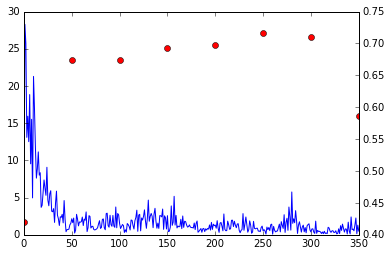

In [16]:
fig, ax = plt.subplots(1)
ax.plot(mean_losses)
ax2 = plt.twinx()
ax2.plot(np.arange(0, n_iterations+1, 50), mean_evals, 'ro')

In [17]:
p = []
for ii in range(169):
    im, la = sess.run([image_test, label_test])
    p.append(sess.run(correct_prediction, feed_dict={this_image:im, this_label:la}))

In [18]:
np.mean(p)

0.65680473372781067